[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dMTdO5vxdVX0NA2Qe7AV9WGEy8ZH67Xn?usp=sharing) &nbsp;[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/haocai1992/GPT2-News-Classifier/blob/main/colab-train/gpt2-news-classifier-colab-train.ipynb)

## Install and import packages

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm
from datasets import load_dataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
classification_langs = ['java', 'python', 'pharo']
classification_labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}

## Read data

In [3]:
import pandas as pd

In [4]:
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')

In [21]:
df_train = pd.DataFrame(ds['java_train'])
df_test = pd.DataFrame(ds['java_test'])
df_train.head()

,index,class,comment_sentence,partition,combo,labels
0,0,Abfss.java,azure blob file system implementation of abstr...,0,azure blob file system implementation of abstr...,"[1, 0, 0, 0, 0, 0, 0]"
1,1,Abfss.java,this impl delegates to the old filesystem,0,this impl delegates to the old filesystem | Ab...,"[0, 0, 1, 0, 0, 0, 0]"
2,2,AbstractContractGetFileStatusTest.java,test getfilestatus and related listing operati...,0,test getfilestatus and related listing operati...,"[1, 0, 0, 0, 0, 0, 0]"
3,11,AbstractContractGetFileStatusTest.java,path filter which only expects paths whose fin...,0,path filter which only expects paths whose fin...,"[0, 0, 1, 0, 0, 0, 0]"
4,15,AbstractContractGetFileStatusTest.java,a filesystem filter which exposes the protecte...,0,a filesystem filter which exposes the protecte...,"[0, 0, 1, 0, 0, 0, 0]"


In [22]:
# replace one-hot encoded labels with integers
def onehot_to_string(row):
    for i, val in enumerate(row):
        if val == 1:
            return classification_labels['java'][i]
    return None

df_train['labels'] = df_train['labels'].apply(onehot_to_string)
df_test['labels'] = df_test['labels'].apply(onehot_to_string)

df_train.head()

,index,class,comment_sentence,partition,combo,labels
0,0,Abfss.java,azure blob file system implementation of abstr...,0,azure blob file system implementation of abstr...,summary
1,1,Abfss.java,this impl delegates to the old filesystem,0,this impl delegates to the old filesystem | Ab...,Expand
2,2,AbstractContractGetFileStatusTest.java,test getfilestatus and related listing operati...,0,test getfilestatus and related listing operati...,summary
3,11,AbstractContractGetFileStatusTest.java,path filter which only expects paths whose fin...,0,path filter which only expects paths whose fin...,Expand
4,15,AbstractContractGetFileStatusTest.java,a filesystem filter which exposes the protecte...,0,a filesystem filter which exposes the protecte...,Expand


<Axes: xlabel='labels'>

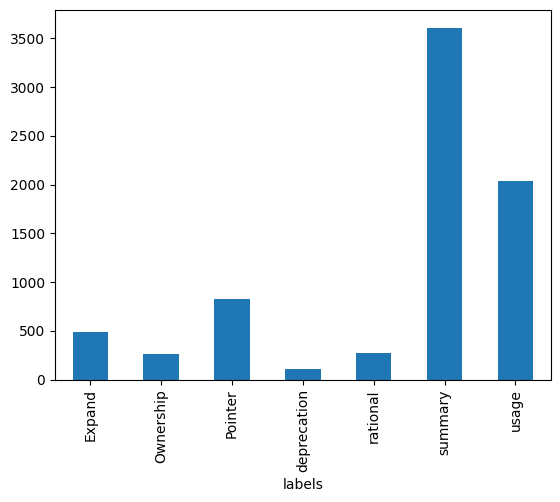

In [23]:
df_train.groupby("labels").size().plot.bar()

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [24]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [25]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [26]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [27]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [28]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


## Dataset class

PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training. See more details [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Here we will build a custom Dataset class to read in our news data, tokenize them, and store them into containers for batch training.

In [29]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "summary": 0,
    "Ownership": 1,
    "Expand": 2,
    "usage": 3,
    "Pointer": 4,
    "deprecation": 5,
    "rational": 6
}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['labels']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['comment_sentence']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [30]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [42]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.type(torch.LongTensor)
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.type(torch.LongTensor)
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=7, max_seq_len=256, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_test, LR, EPOCHS)

  0%|          | 0/3807 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x98304 and 196608x7)

Looks like the model is already well trained after 1 epoch! This is probably due to the fact that as a pre-trained model with gigantic number of parameters, GPT-2 is already capable of differentiating different text paragraphs without too much tuning.

## Evaluation

After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the `evaluate` function according [this PyTorch guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

In [35]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.819


Another good gauge of model performance is the confusion matrix.

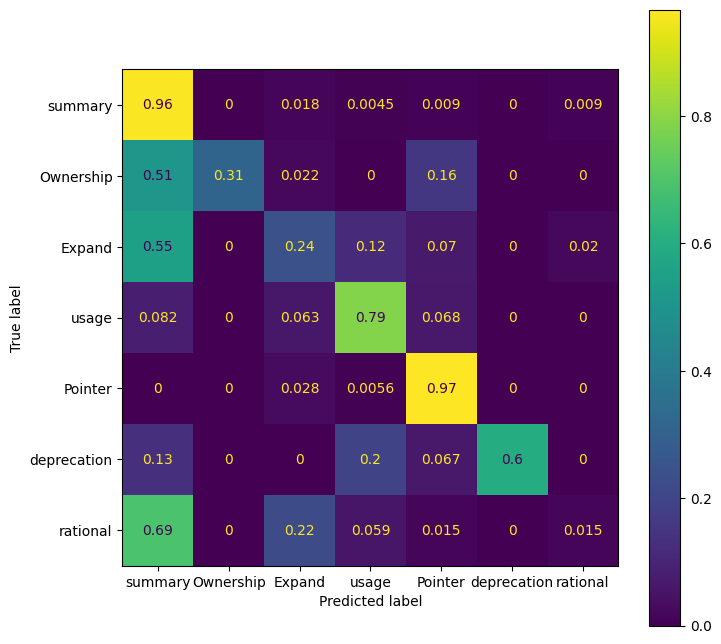

In [36]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

In [37]:
# Print classification report.
from sklearn.metrics import classification_report

print(classification_report(y_true=true_labels, y_pred=pred_labels, target_names=list(labels.keys())))

              precision    recall  f1-score   support

     summary       0.84      0.96      0.90       892
   Ownership       1.00      0.31      0.47        45
      Expand       0.27      0.24      0.26       100
       usage       0.93      0.79      0.85       427
     Pointer       0.76      0.97      0.85       178
 deprecation       1.00      0.60      0.75        15
    rational       0.09      0.01      0.03        68

    accuracy                           0.82      1725
   macro avg       0.70      0.55      0.59      1725
weighted avg       0.80      0.82      0.80      1725

